### For demo purposes, we use sample data instead of the full data as input:

In [1]:
demo_mode = True

### Load generated layouts and VQAV2 data (processed):

In [4]:
import numpy as np
import json
if not demo_mode:
    layout_data = json.load(open("../../layout_new/layout_new.json", 'rb'))
    image_data = json.load(open("../../VQAv2/data.json", 'rb'))
else:
    layout_data = {"8": [		{			"layout_id": "8_0",			"layout_size": [				1000,				1000			],			"pos": [				[					112,					502,					279,					669				],				[					187,					67,					354,					234				],				[					662,					617,					829,					784				],				[					347,					567,					514,					734				],				[					67,					282,					234,					449				],				[					567,					157,					734,					324				],				[					287,					287,					454,					454				],				[					597,					387,					764,					554				]			],			"positional_descriptor": [				"8_0_0",				"8_0_1",				"8_0_2",				"8_0_3",				"8_0_4",				"8_0_5",				"8_0_6",				"8_0_7"			],			"image": "../../layout_new/8_0.jpg"		},]}
    image_data = {"8":{"What is the animal?": [	{		"image_id": 524621,		"question": "What is the animal?",		"question_id": 524621007,		"answer": "giraffe",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000524621.jpg"		}	},	{		"image_id": 27617,		"question": "What is the animal?",		"question_id": 27617005,		"answer": "dog",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000027617.jpg"		}	},	{		"image_id": 166563,		"question": "What is the animal?",		"question_id": 166563002,		"answer": "elephant",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000166563.jpg"		}	},	{		"image_id": 28872,		"question": "What is the animal?",		"question_id": 28872003,		"answer": "horse",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000028872.jpg"		}	},	{		"image_id": 192730,		"question": "What is the animal?",		"question_id": 192730001,		"answer": "cow",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000192730.jpg"		}	},	{		"image_id": 351297,		"question": "What is the animal?",		"question_id": 351297003,		"answer": "giraffe",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000351297.jpg"		}	},	{		"image_id": 91564,		"question": "What is the animal?",		"question_id": 91564002,		"answer": "sheep",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000091564.jpg"		}	},	{		"image_id": 509891,		"question": "What is the animal?",		"question_id": 509891002,		"answer": "elephant",		"answer_type": "other",		"target_img": {			"path": "val2014/",			"name": "COCO_val2014_000000509891.jpg"		}	}]}}

### Randomly select questions with image sets from the VQA dataset:

In [3]:
import random
if demo_mode:
    num_questions = 1
else:
    num_questions = 6
unique_ids = [['8', random.choice(list(image_data['8'].keys()))] for i in range(num_questions)]
random_ids = [i[1] for i in unique_ids]


In [10]:
import requests
from PIL import Image
from io import BytesIO
if demo_mode:
    base_dataset_image_path = "https://multipanel.s3.us-east-2.amazonaws.com/"
else:
    base_dataset_image_path = '../../VQA/'


### Preview images

In [ ]:
import matplotlib.pyplot as plt

for i in range(8):
    image_path = image_data[unique_ids[0][0]][unique_ids[0][1]][i]['target_img']
    if demo_mode:
        response = requests.get(base_dataset_image_path + image_path['name'])
        image = Image.open(BytesIO(response.content))
    else:
        image = plt.imread(base_dataset_image_path + image_path['path'] + image_path['name'])
    plt.imshow(image)
    plt.show()

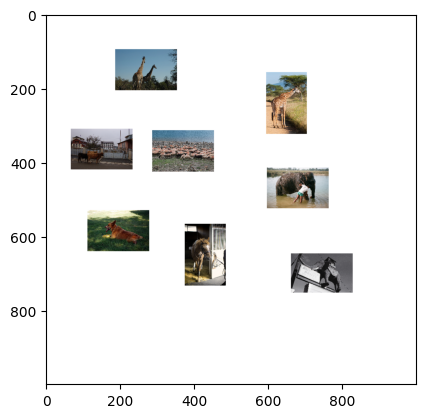

In [21]:
import math,cv2, os
import random
import numpy as np
# Load input images - assume we have a list of image paths in the correct order
test_set = []
set_source = 'VQA'
for q, im_set in enumerate(unique_ids):
    im_set = im_set[1]
    for num in range(1,9): # num of sub images
        if str(num) in layout_data.keys():
            for n in range(len(layout_data[str(num)])):
                wall_gallery = np.ones((1000, 1000, 3), dtype=np.uint8) * 255

                test_data_ = {}
                test_data_['set_source'] = set_source
                layout = layout_data[str(num)][n]

                for i in range(8):
                    if not image_data['8'][im_set][i]['answer'] in [image_data['8'][im_set][j]['answer'] for j in range(8) if j != i]:
                        test_data_['qa_target_subimage_idx'] = i
                        break
                image_data['8'][im_set] = [image_data['8'][im_set][i]]+[image_data['8'][im_set][j] for j in range(8) if j != i]
                
                test_data_['layout'] = layout
                frames = layout['pos']
                images_list = image_data['8'][im_set]
                test_data_['sub_images'] = []
                image_paths = []
                
                path_to_idx = {}
                for p in range(len(images_list)):
                    path_to_idx[images_list[p]['target_img']['path']] = []
                
                test_data_['sub_image_relations'] = {}

                for j in range(min(num, len(images_list))):
                    sub_image_dict = {}
                    # assert j==0 or 'target' in images_list[j]['source_img']['path']

                    image_paths.append([images_list[j]['target_img']['path'], images_list[j]['target_img']['name']])
                    sub_image_dict['image_paths'] = image_path
                    sub_image_dict['positional_descriptor'] = layout['positional_descriptor'][j]
                    if sub_image_dict['positional_descriptor'].split('_')[-1] == '0':
                        test_data_['qa_target_subimage_idx'] = j
                    if not images_list[j]['answer_type'] + '|' + images_list[j]['question'] + '|' + images_list[j]['answer'] in test_data_['sub_image_relations']:
                        test_data_['sub_image_relations'][images_list[j]['answer_type'] + '|' + images_list[j]['question'] + '|' + images_list[j]['answer']] = []
                    test_data_['sub_image_relations'][images_list[j]['answer_type'] + '|' + images_list[j]['question'] + '|' + images_list[j]['answer']].append(j)
                    
                    test_data_['sub_images'].append(sub_image_dict)


                # Composite each image into the detected frames
                for (x1, y1, x2, y2), image_path in zip(frames, image_paths):
                    # Load the image
                    if demo_mode:
                        response = requests.get(base_dataset_image_path + image_path[1])
                        image = np.array(Image.open(BytesIO(response.content)))
                    else:
                        image = cv2.imread(os.path.join(base_dataset_image_path,image_path[0], image_path[1]))
                    
                    # Calculate the aspect ratio of the image
                    image_aspect_ratio = image.shape[1] / image.shape[0]
                    
                    # Calculate the aspect ratio of the frame
                    frame_aspect_ratio = (x2 - x1) / (y2 - y1)
                    
                    # Determine the maximum size of the image that can fit in the frame while maintaining the aspect ratio
                    if image_aspect_ratio > frame_aspect_ratio:
                        # The width of the image is the limiting factor
                        resized_width = x2 - x1
                        resized_height = math.floor(resized_width / image_aspect_ratio)
                    else:
                        # The height of the image is the limiting factor
                        resized_height = y2 - y1
                        resized_width = math.floor(resized_height * image_aspect_ratio)
                    
                    # Resize the image to fit the frame
                    resized_image = cv2.resize(image, (resized_width, resized_height))
                    
                    # Place the image in the frame
                    x_offset = x1 + math.floor((x2 - x1 - resized_width) / 2)
                    y_offset = y1 + math.floor((y2 - y1 - resized_height) / 2)
                    wall_gallery[y_offset:y_offset+resized_height, x_offset:x_offset+resized_width] = resized_image

                # Save the composited image
                img_name = str(q)+ '_'+str(num)+'_'+str(n)+'.png'
                if demo_mode:
                        plt.imshow(wall_gallery)
                        plt.show()
                else:
                    cv2.imwrite(img_name, wall_gallery)
                test_data_['composited_gallery'] = img_name
                
                test_set.append(test_data_)